In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
#LAKE 
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Sagamore Lake'))


# STATION 
Polygon_geometry_sagamore_lake = ee.Geometry.Polygon([[
    [-74.619453, 43.7688],
    [-74.620204, 43.767653],
    [-74.61881, 43.767328],
    [-74.618188, 43.768072],
    [-74.619453, 43.7688]
]])


Map.addLayer(Polygon_geometry_sagamore_lake)
Map.centerObject(Polygon_geometry_sagamore_lake, 16)
Map

Map(center=[43.76798714795235, -74.61919960869463], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
#Map.user_roi.getInfo()


In [6]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [7]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(Polygon_geometry_sagamore_lake).updateMask(mask)

#return img.addBands(co).clip(lake).updateMask(mask)


# Masking Clouds

In [8]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(1,12, 'month')) \
    .filterBounds(Polygon_geometry_sagamore_lake) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .map(cdom)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25)) 

In [9]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [10]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [11]:
 first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [12]:
#How many images?
print(s2.size().getInfo())


56


# CDOM Value Over Station

In [27]:
def station_mean(img): # station_mean function with a single parameter img
    #mean of a specific band (CO) within a region 
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=Polygon_geometry_sagamore_lake, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,2019-06-15T16:01:07,6.648446
1,2019-07-10T16:01:15,6.163295
2,2019-08-14T16:01:07,3.994657
3,2019-09-13T16:01:02,7.302880
4,2019-09-18T16:01:03,189.829436
5,2019-10-08T16:01:05,1567.974628
6,2019-10-13T16:01:07,7.900000
7,2019-11-17T16:01:02,404.787940
8,2020-03-01T16:00:59,7.579763
9,2020-03-16T16:01:02,7.506433


In [28]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2019-06-15,6.648446
1,2019-07-10,6.163295
2,2019-08-14,3.994657
3,2019-09-13,7.302880
4,2019-09-18,189.829436
5,2019-10-08,1567.974628
6,2019-10-13,7.900000
7,2019-11-17,404.787940
8,2020-03-01,7.579763
9,2020-03-16,7.506433


In [29]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

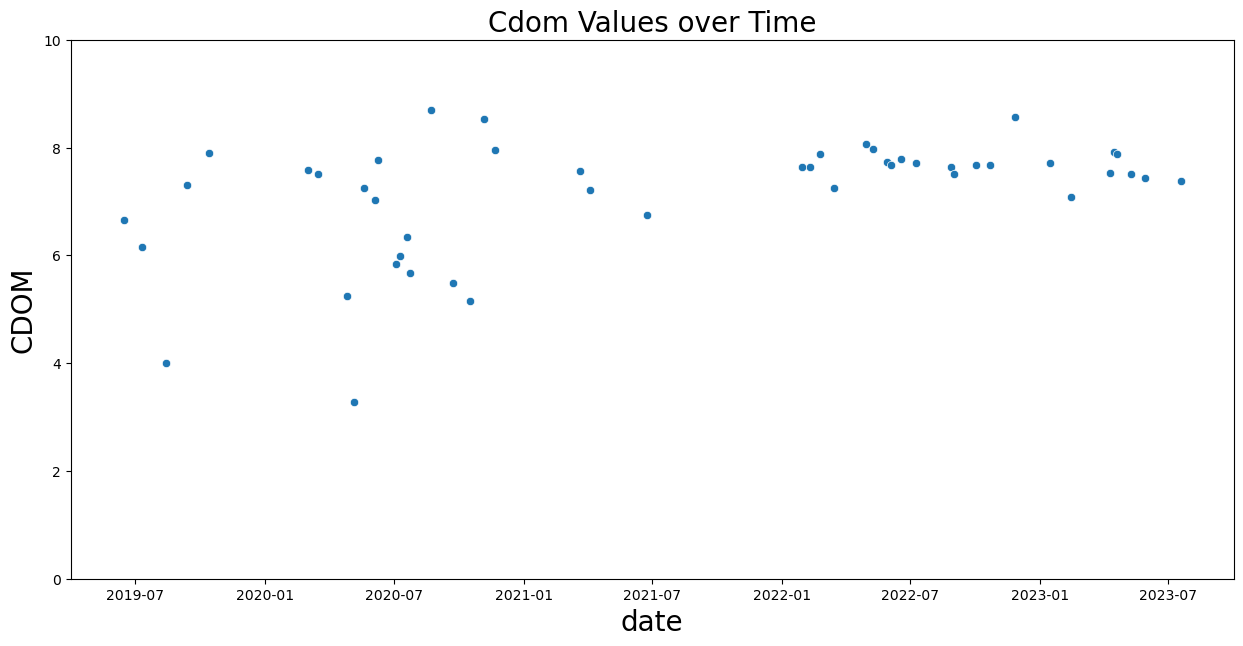

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


# Reflectance Values

In [17]:
def reflectance(img): 
    #img is used to calculate the mean of specific bands indicated by STD_NAMES
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=Polygon_geometry_sagamore_lake, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2019-06-15,"{'Aerosols': 449.13321926179424, 'Blue': 357.0..."
1,2019-07-10,"{'Aerosols': 337.9787338059154, 'Blue': 351.89..."
2,2019-08-14,"{'Aerosols': 170.49132241505748, 'Blue': 120.1..."
3,2019-09-13,"{'Aerosols': 115.52065509655338, 'Blue': 101.2..."
4,2019-09-18,"{'Aerosols': 3.996333414813004, 'Blue': 36.490..."
5,2019-10-08,"{'Aerosols': 1, 'Blue': 5.198973356147642, 'Gr..."
6,2019-10-13,"{'Aerosols': 1, 'Blue': 1, 'Green': 1, 'NIR': ..."
7,2019-11-17,"{'Aerosols': 1.150239234449761, 'Blue': 2.0993..."
8,2020-03-01,"{'Aerosols': 10153.591297971154, 'Blue': 9849...."
9,2020-03-16,"{'Aerosols': 4490.904179907114, 'Blue': 4503.2..."


In [18]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



         Band   Reflectance        Date
0    Aerosols    449.133219  2019-06-15
1        Blue    357.010022  2019-06-15
2       Green    322.895380  2019-06-15
3         Red    300.769494  2019-06-15
4    RedEdge1    310.716206  2019-06-15
5    RedEdge2    284.697385  2019-06-15
6    RedEdge4    258.693718  2019-06-15
7         NIR    285.323637  2019-06-15
8       SWIR1    274.789049  2019-06-15
9    Aerosols    337.978734  2019-07-10
10       Blue    351.892691  2019-07-10
11      Green    320.055732  2019-07-10
12        Red    244.615497  2019-07-10
13   RedEdge1    295.888291  2019-07-10
14   RedEdge2    486.340015  2019-07-10
15   RedEdge4    503.823515  2019-07-10
16        NIR    479.482034  2019-07-10
17      SWIR1    128.412613  2019-07-10
18   Aerosols    170.491322  2019-08-14
19       Blue    120.101931  2019-08-14
20      Green     91.036177  2019-08-14
21        Red     71.496211  2019-08-14
22   RedEdge1     66.511611  2019-08-14
23   RedEdge2     56.455634  2019-08-14


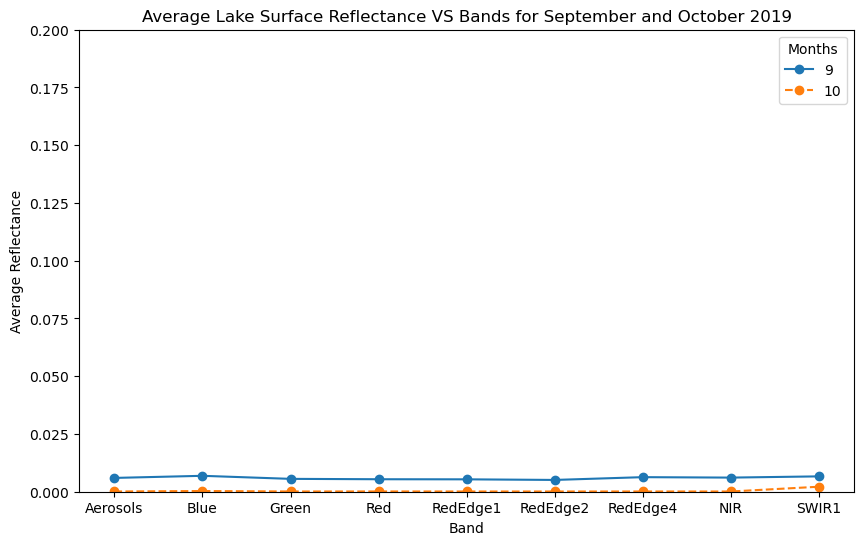

Data table for Month 9:
        band  reflectance
0   Aerosols     0.011552
1       Blue     0.010128
2      Green     0.009757
3        Red     0.009390
4   RedEdge1     0.010230
5   RedEdge2     0.010068
6   RedEdge4     0.011452
7        NIR     0.011786
8      SWIR1     0.010860
9   Aerosols     0.000400
10      Blue     0.003649
11     Green     0.001375
12       Red     0.001422
13  RedEdge1     0.000497
14  RedEdge2     0.000136
15  RedEdge4     0.001157
16       NIR     0.000442
17     SWIR1     0.002431

Data table for Month 10:
        band  reflectance
0   Aerosols     0.000100
1       Blue     0.000520
2      Green     0.000113
3        Red     0.000141
4   RedEdge1     0.000100
5   RedEdge2     0.000100
6   RedEdge4     0.000109
7        NIR     0.000100
8      SWIR1     0.002146
9   Aerosols     0.000100
10      Blue     0.000100
11     Green     0.000100
12       Red     0.000100
13  RedEdge1     0.000100
14  RedEdge2     0.000100
15  RedEdge4     0.000109
16       NIR  

In [19]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month in [9, 10]:  # Filter for September (9) and October (10) only
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--']  # List of line styles for two months
style_index = 0

for month, data in data_by_month.items():
    band_averages = {band: sum(data['reflectance'][i] for i, b in enumerate(data['band']) if b == band) / data['band'].count(band) for band in STD_NAMES}
    bands = list(band_averages.keys())
    reflectance_values = list(band_averages.values())
    
    line_style = line_styles[style_index]  # Cycle through line styles
    
    plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}')
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend(title='Months')
plt.show()

# Display the data table for September and October
for month, data in data_by_month.items():
    print(f"Data table for Month {month}:")
    df = pd.DataFrame(data)
    print(df)
    print()



In [20]:
#Average band reflectance values for each month
data_by_month = {}

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'reflectance_values': {band: [] for band in STD_NAMES}}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['reflectance_values'][band].append(value)

# Calculate the average reflectance values for each band within each month
average_data = {'band': [], 'average_reflectance': []}

for month, data in data_by_month.items():
    for band, reflectance_values in data['reflectance_values'].items():
        if reflectance_values:  # Check if reflectance_values is not empty
            average_value = sum(reflectance_values) / len(reflectance_values)
            average_data['band'].append(band)
            average_data['average_reflectance'].append(average_value)

# Create a dataframe from the average data
df_average_data = pd.DataFrame(average_data)

# Display the dataframe
print(df_average_data)



        band  average_reflectance
0   Aerosols             0.044913
1       Blue             0.035701
2      Green             0.032290
3        Red             0.030077
4   RedEdge1             0.031072
5   RedEdge2             0.028470
6   RedEdge4             0.025869
7        NIR             0.028532
8      SWIR1             0.027479
9   Aerosols             0.033798
10      Blue             0.035189
11     Green             0.032006
12       Red             0.024462
13  RedEdge1             0.029589
14  RedEdge2             0.048634
15  RedEdge4             0.050382
16       NIR             0.047948
17     SWIR1             0.012841
18  Aerosols             0.017049
19      Blue             0.012010
20     Green             0.009104
21       Red             0.007150
22  RedEdge1             0.006651
23  RedEdge2             0.005646
24  RedEdge4             0.006038
25       NIR             0.005074
26     SWIR1             0.005322
27  Aerosols             0.005976
28      Blue  

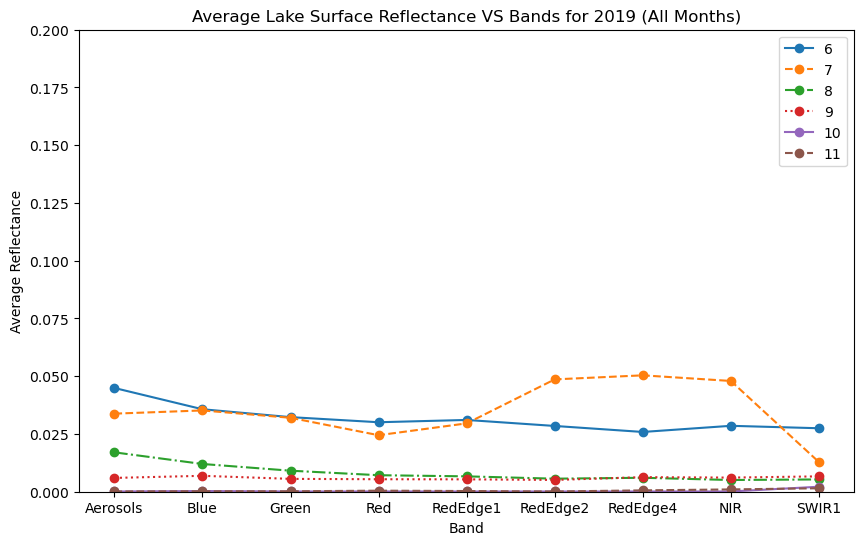

In [21]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()




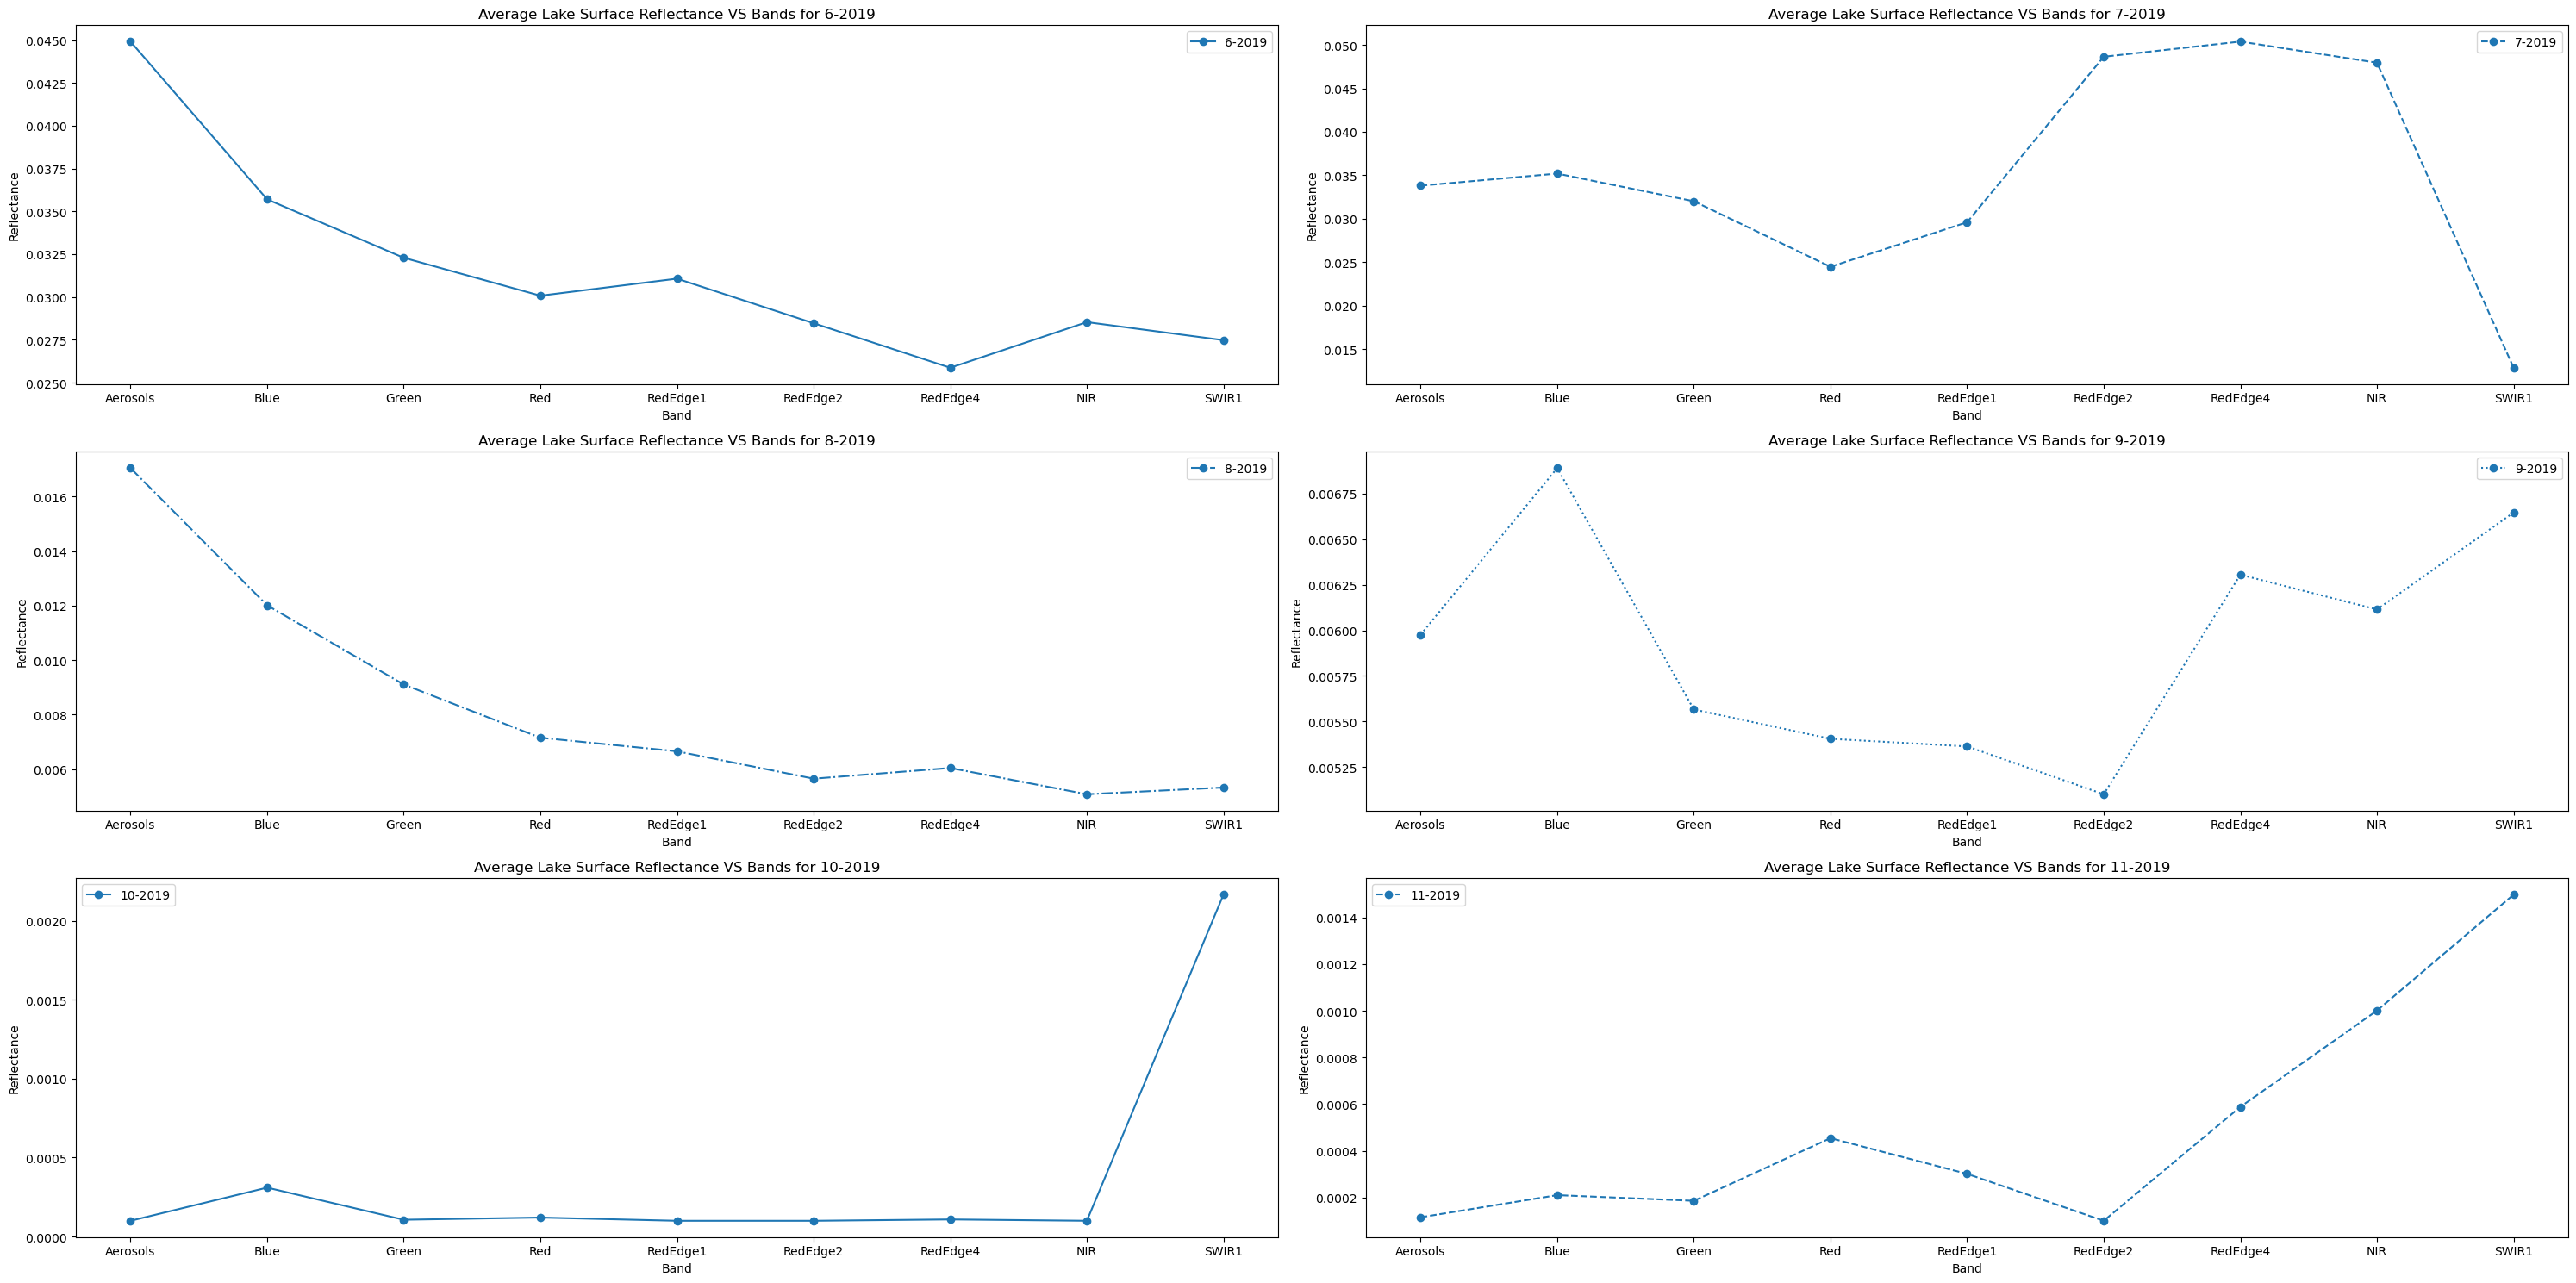

In [22]:
import numpy as np

data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)
                else:
                    data_by_month[month][band].append(np.nan)

# Calculate the average reflectance values for each band within each month
averages_by_month = {
    month: {band: np.nanmean(values) for band, values in data.items()}
    for month, data in data_by_month.items()
}

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(averages_by_month.items()):
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
    axs[i].set_title(f'Average Lake Surface Reflectance VS Bands for {month}-2019')
    
    bands = list(data.keys())
    reflectance_values = list(data.values())
    axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-2019')
    
    axs[i].legend()

plt.tight_layout()
plt.show()





# DOC

In [23]:
# ONLY FOR 2019 


import pandas as pd

# Read the data from the Excel file
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Select the 'DATE_SMP' and 'DOC_MG_L' columns and filter by specific_site_id
specific_site_id = '1A1-103'  # BIG_MOOSE_LAKE
data = data_doc[data_doc['SITE_ID'] == specific_site_id][['DATE_SMP', 'DOC_MG_L','SITE_ID']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})

# Filter the data for the year 2019
data_2019 = data[data['Date'].dt.year == 2019]

# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data_2019)

            Date       DOC  SITE_ID
18861 2019-02-05  7.659300  1A1-103
38335 2019-04-02  6.400300  1A1-103
37120 2019-05-01  5.958300  1A1-103
16544 2019-07-09  5.888300  1A1-103
1887  2019-09-04  5.505700  1A1-103
38346 2019-11-14  7.429081  1A1-103


In [24]:
# 2019_Onwards 

import pandas as pd

# Read the data from the Excel file
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Select the 'DATE_SMP' and 'DOC_MG_L' columns and filter by specific_site_id
specific_site_id = '1A1-103'  # BIG_MOOSE_LAKE
data = data_doc[data_doc['SITE_ID'] == specific_site_id][['DATE_SMP', 'DOC_MG_L','SITE_ID']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})

# Filter the data for the year 2019 onwards
data_2019_onwards = data[data['Date'].dt.year >= 2019]

# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data_2019_onwards)


            Date       DOC  SITE_ID
18861 2019-02-05  7.659300  1A1-103
38335 2019-04-02  6.400300  1A1-103
37120 2019-05-01  5.958300  1A1-103
16544 2019-07-09  5.888300  1A1-103
1887  2019-09-04  5.505700  1A1-103
38346 2019-11-14  7.429081  1A1-103
37128 2020-02-03  7.373080  1A1-103
5568  2020-05-28  5.758763  1A1-103
32198 2020-07-14  5.007855  1A1-103
16554 2020-09-01  4.970554  1A1-103
3125  2020-11-05  5.042800  1A1-103
28525 2021-02-03  6.499600  1A1-103
34632 2021-04-01  7.029300  1A1-103
1901  2021-05-04  6.989800  1A1-103
8040  2021-07-15  5.821500  1A1-103
11687 2021-09-02  7.912200  1A1-103


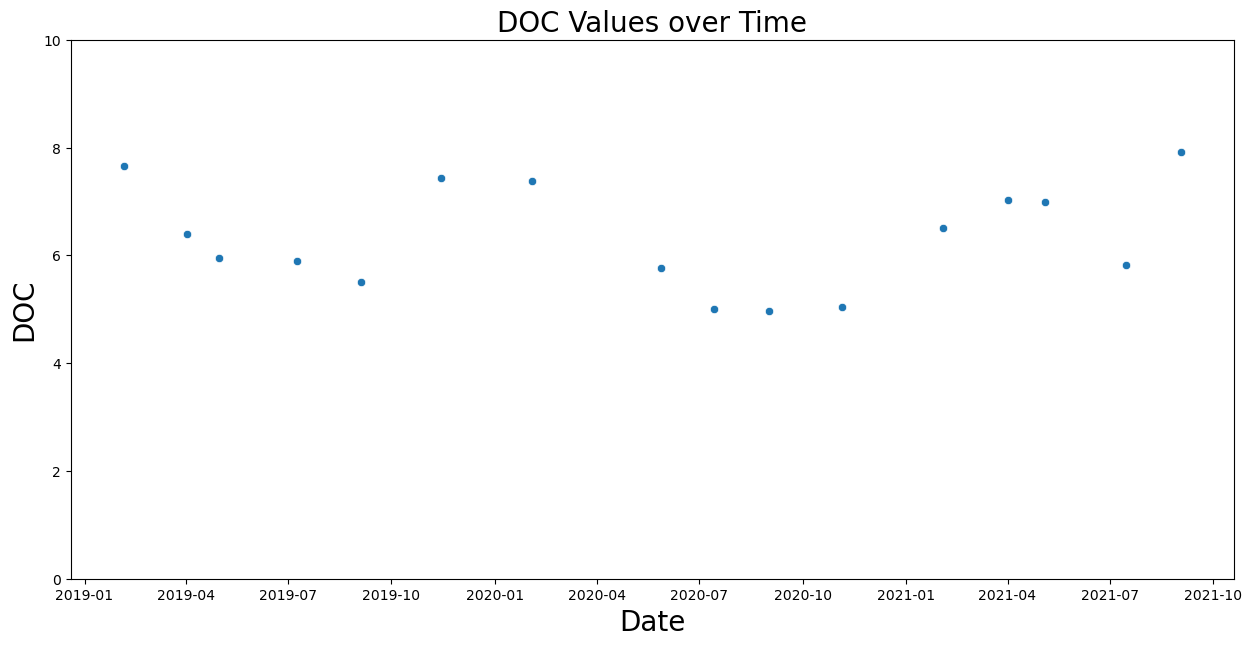

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data_2019_onwards, x='Date', y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time', fontsize=20)
ax.set_ylim(0, 10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


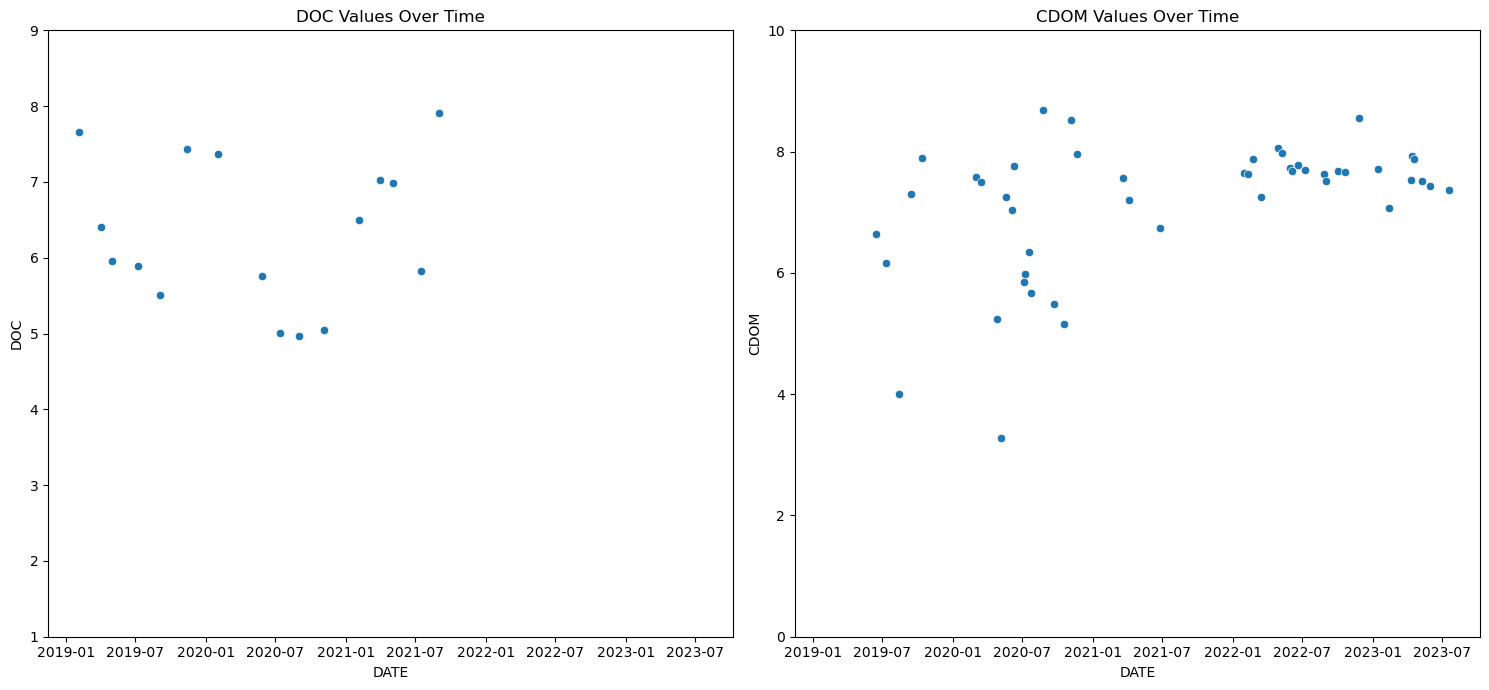

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data_2019_onwards, x='Date', y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_ylim(1,9)

ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_ylim(0,10)
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

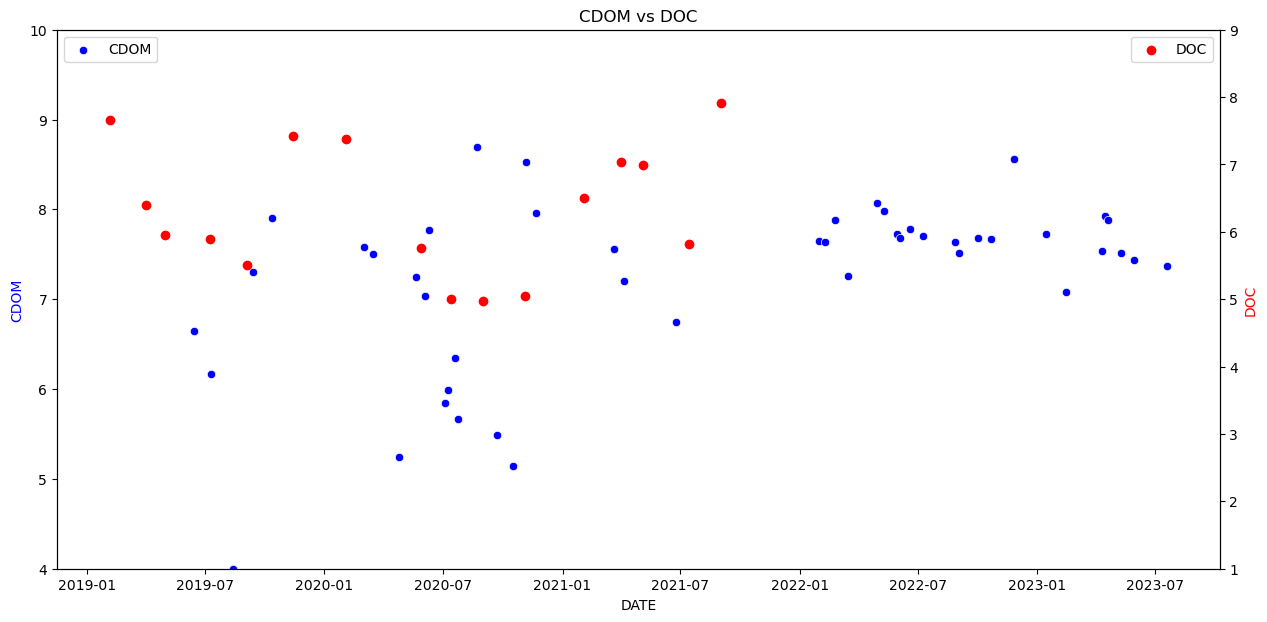

In [32]:
# CDOM vs DOC Timeseries 
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data_2019_onwards['Date'], data_2019_onwards['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(4,10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

In [33]:
# Sort the doc DataFrame by date in ascending order
data = data.sort_values(by='Date')

# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Perform inner merge with seven-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='Date', tolerance=pd.Timedelta(days=5))

# Get rid of the null values from doc
merged_inner = merged_inner.dropna()

print(merged_inner)




         date        CDOM       Date       DOC  SITE_ID
1  2019-07-10    6.163295 2019-07-09  5.888300  1A1-103
7  2019-11-17  404.787940 2019-11-14  7.429081  1A1-103
17 2020-07-19    6.345934 2020-07-14  5.007855  1A1-103
23 2020-11-06    8.529192 2020-11-05  5.042800  1A1-103
26 2021-04-05    7.203989 2021-04-01  7.029300  1A1-103


In [34]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner)

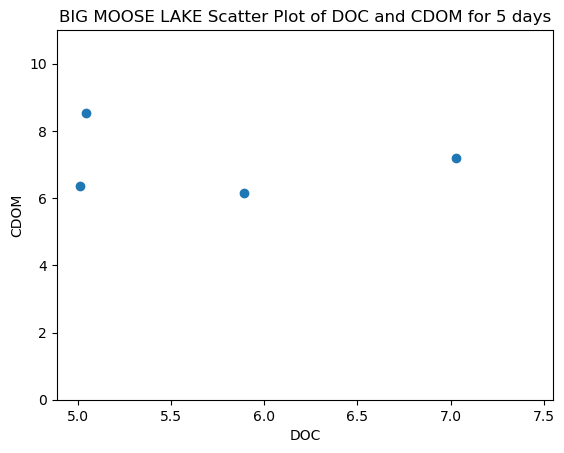

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])
# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('BIG MOOSE LAKE Scatter Plot of DOC and CDOM for 5 days')
plt.ylim(0,11)
# Displaying the plot
plt.show()

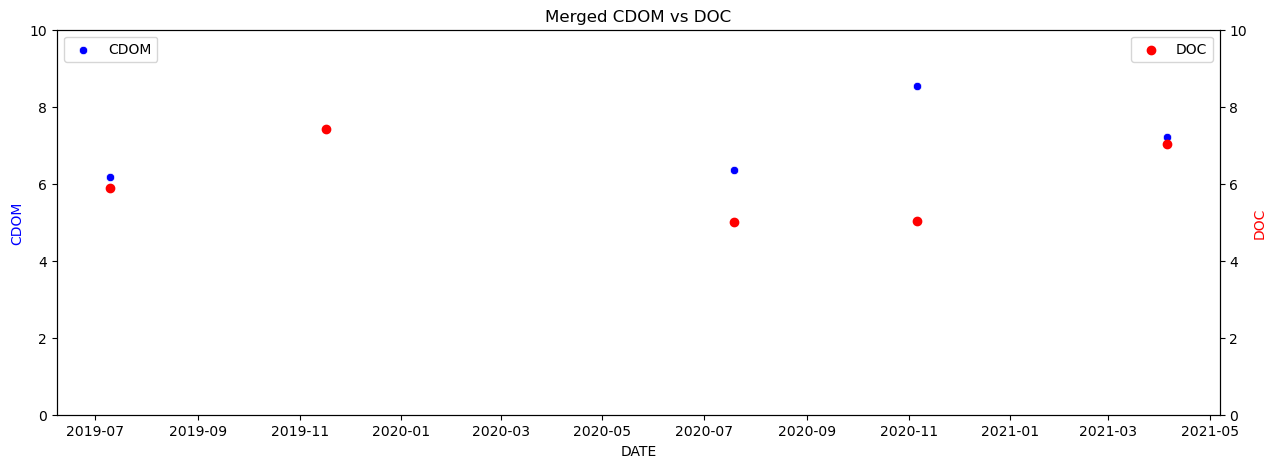

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 5))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

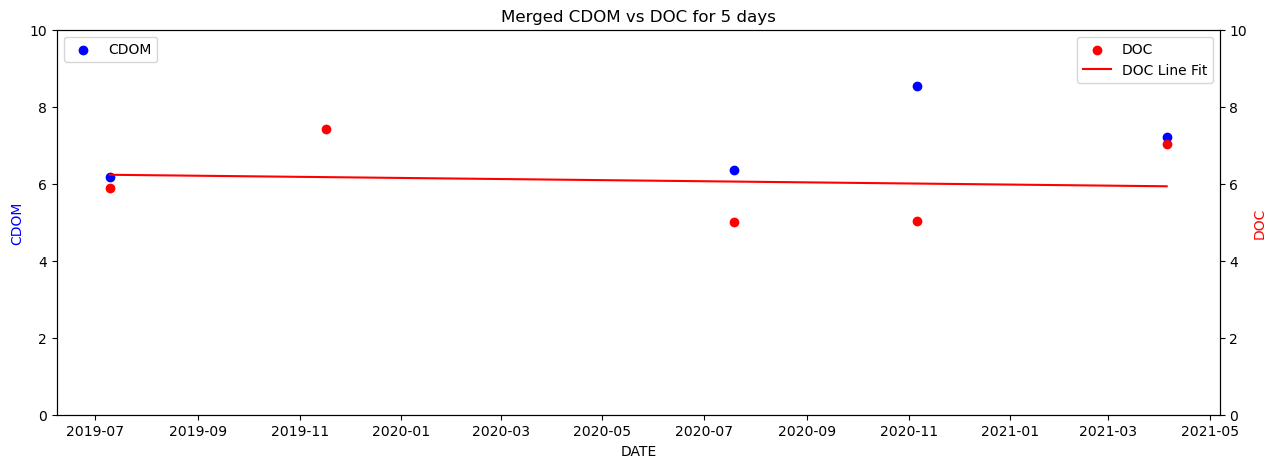

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert the date values to numeric format
merged_inner['date_numeric'] = pd.to_numeric(merged_inner['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 5))

# Matplotlib scatter plot 
ax.scatter(merged_inner['date'], merged_inner['CDOM'], label='CDOM', color='blue')


# Create a twin Axes object for DOC
ax2 = ax.twinx()
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')


# Calculate the linear regression line for CDOM
cdom_x = merged_inner['date_numeric']
cdom_y = merged_inner['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
#ax.plot(merged_inner['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = merged_inner['date_numeric']
doc_y = merged_inner['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(merged_inner['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC for 5 days')

# Set different ranges for the y-axes
ax.set_ylim(0, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

# Each Band Reflectance Over Time

In [38]:
# x-axis: Time, y-axis: Bands 
# Do Each bands over Time 
# Do all the Years 

In [39]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)

         Band   Reflectance        Date
0    Aerosols    449.133219  2019-06-15
1        Blue    357.010022  2019-06-15
2       Green    322.895380  2019-06-15
3         Red    300.769494  2019-06-15
4    RedEdge1    310.716206  2019-06-15
5    RedEdge2    284.697385  2019-06-15
6    RedEdge4    258.693718  2019-06-15
7         NIR    285.323637  2019-06-15
8       SWIR1    274.789049  2019-06-15
9    Aerosols    337.978734  2019-07-10
10       Blue    351.892691  2019-07-10
11      Green    320.055732  2019-07-10
12        Red    244.615497  2019-07-10
13   RedEdge1    295.888291  2019-07-10
14   RedEdge2    486.340015  2019-07-10
15   RedEdge4    503.823515  2019-07-10
16        NIR    479.482034  2019-07-10
17      SWIR1    128.412613  2019-07-10
18   Aerosols    170.491322  2019-08-14
19       Blue    120.101931  2019-08-14
20      Green     91.036177  2019-08-14
21        Red     71.496211  2019-08-14
22   RedEdge1     66.511611  2019-08-14
23   RedEdge2     56.455634  2019-08-14


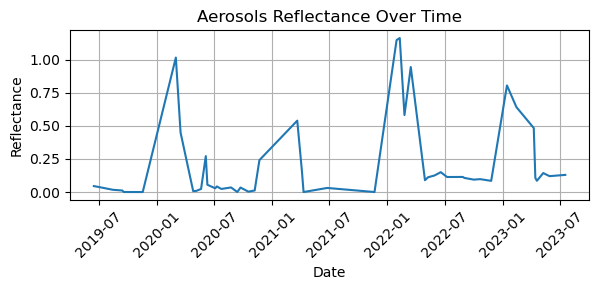

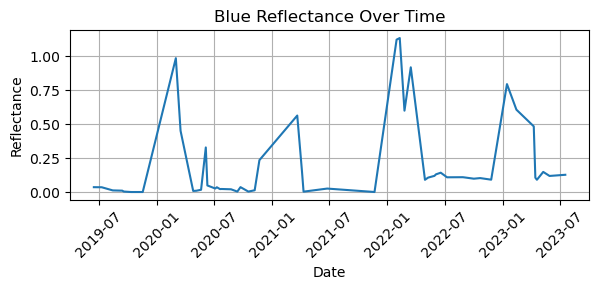

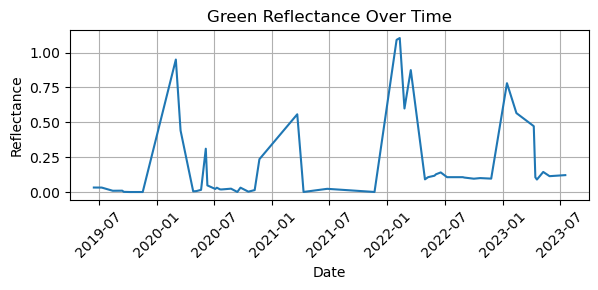

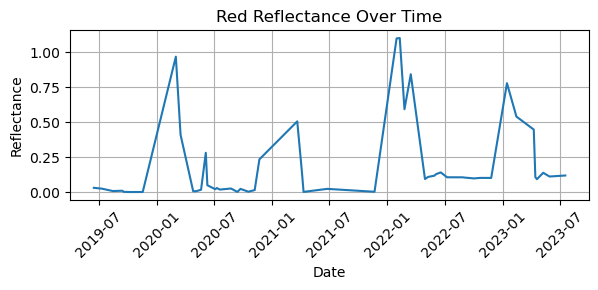

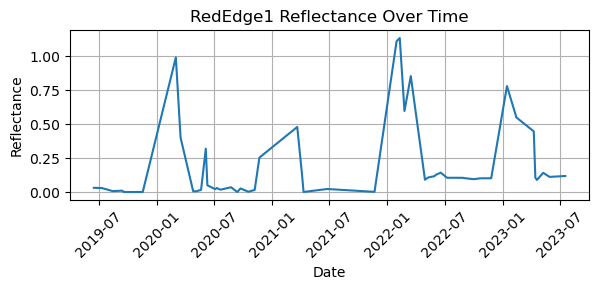

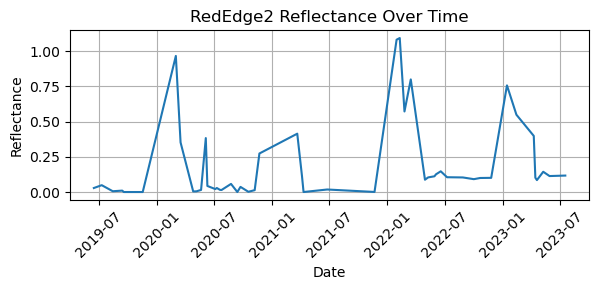

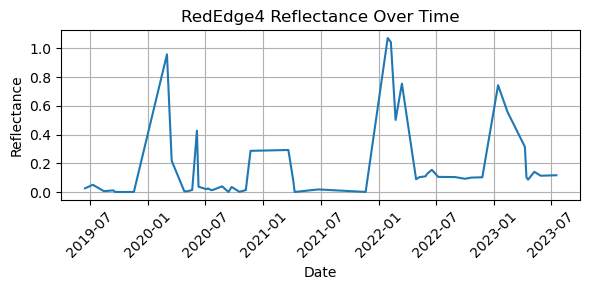

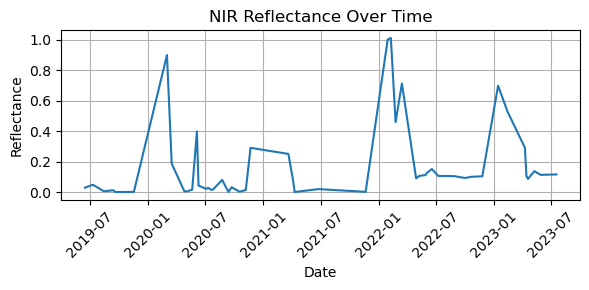

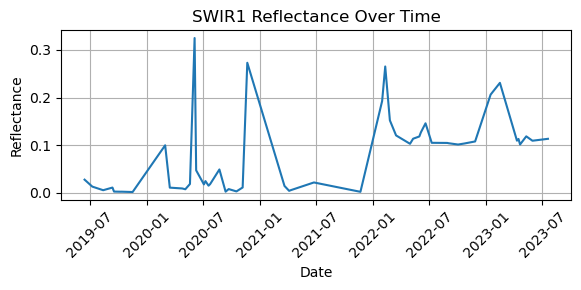

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Loop through each band and create a separate plot for each
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.figure(figsize=(6, 3))  # Adjust the figsize to make the plot smaller
    plt.plot(df_band['Date'], df_band['Reflectance'])
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.title(f'{band} Reflectance Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


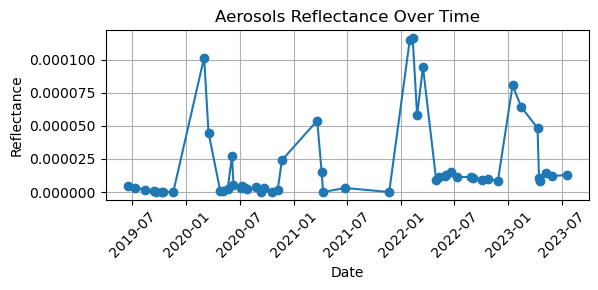

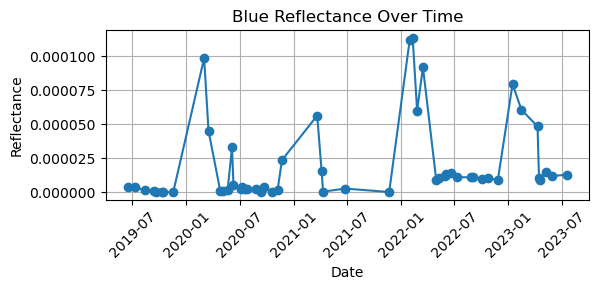

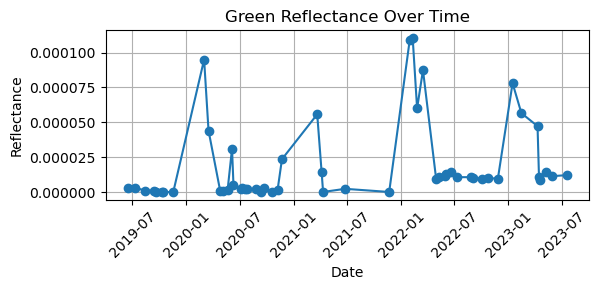

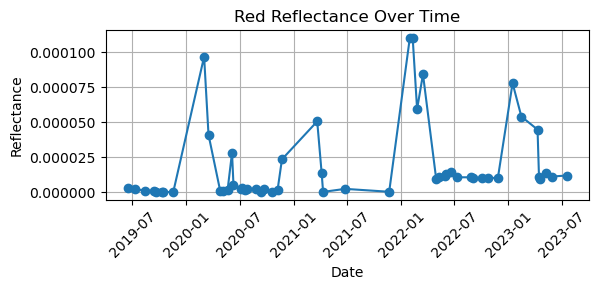

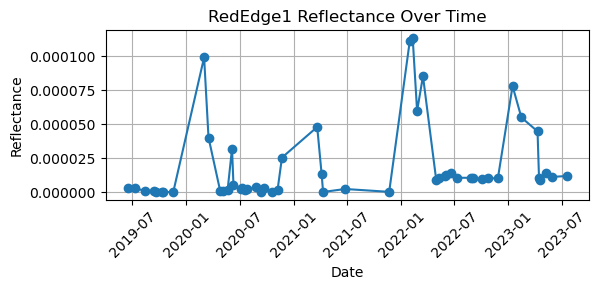

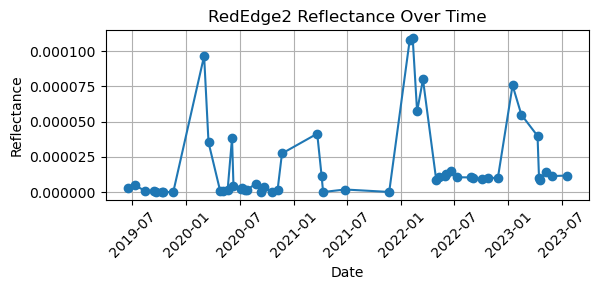

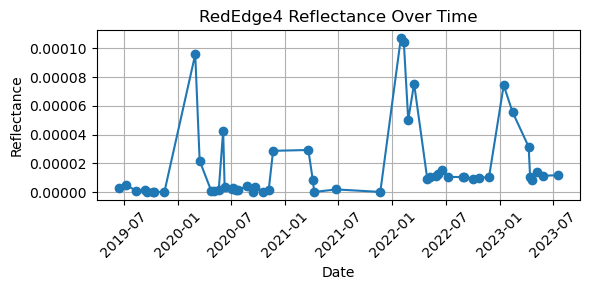

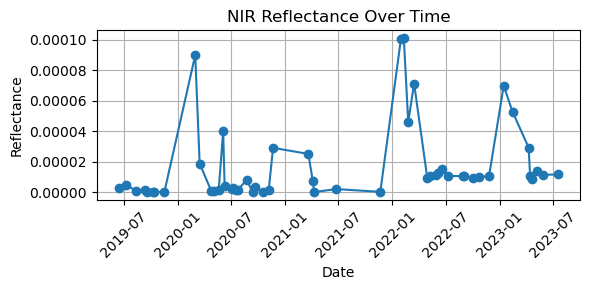

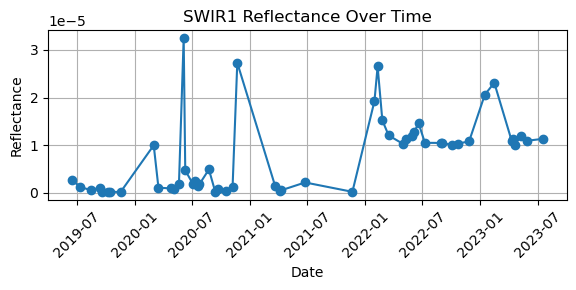

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Loop through each band and create a separate plot for each
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.figure(figsize=(6, 3))  # Adjust the figsize to make the plot smaller
    plt.plot(df_band['Date'], df_band['Reflectance'], marker='o')  # Add marker 'o'
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.title(f'{band} Reflectance Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


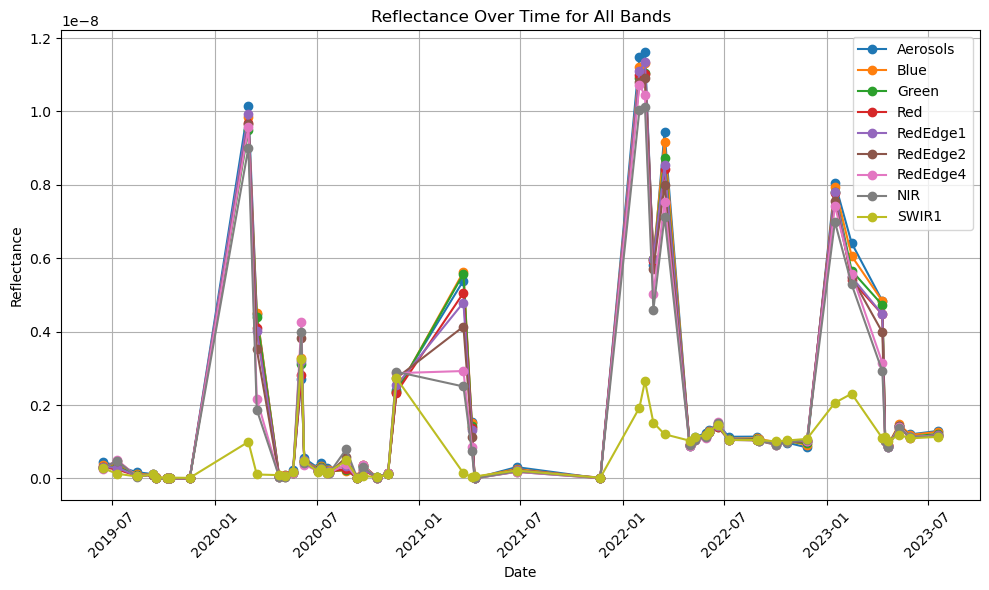

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time for All Bands')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


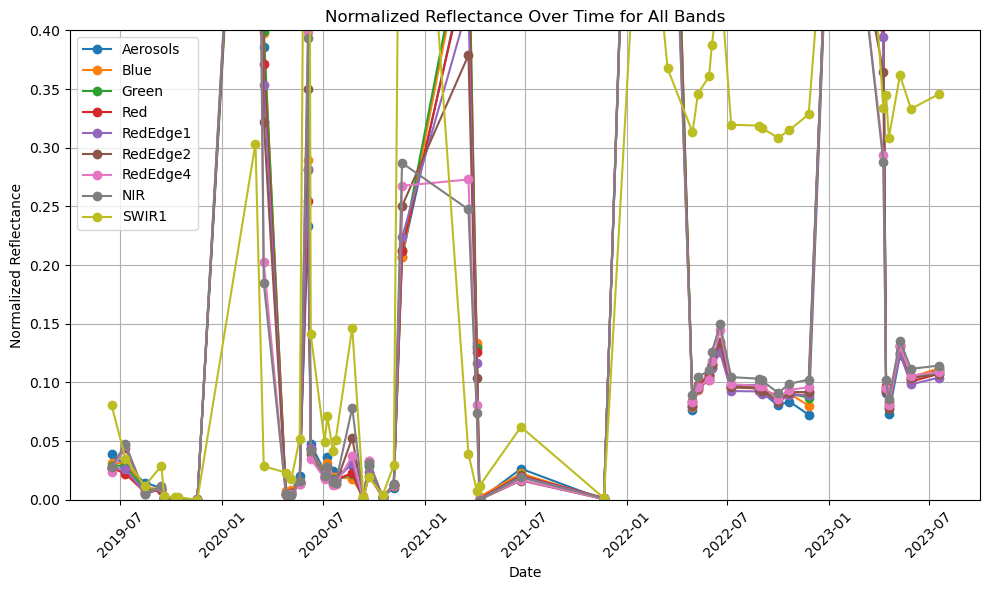

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time for All Bands')
plt.grid(True)
plt.ylim(0,0.4)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


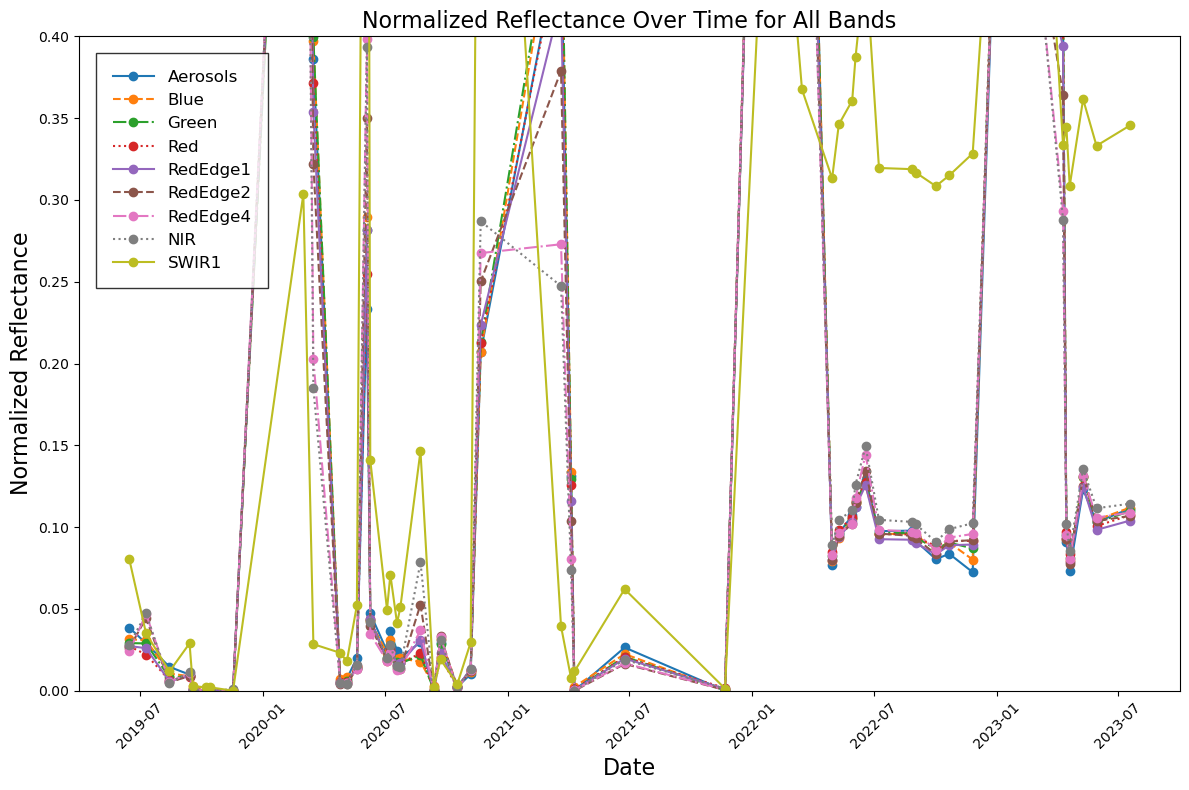

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(12, 8))  # Adjust the figsize to make the plot larger
line_styles = ['-', '--', '-.', ':']  # Different line styles for each band

for idx, band in enumerate(bands):
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band, linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date', fontsize=16)  # Increase text size for x-axis label
plt.ylabel('Normalized Reflectance', fontsize=16)  # Increase text size for y-axis label
plt.title('Normalized Reflectance Over Time for All Bands', fontsize=16)  # Increase text size for title
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(prop={'size': 12}, frameon=True, edgecolor='black', fancybox=False, borderpad=1, borderaxespad=1, handlelength=2.5)  # Make the border bold
plt.tight_layout()
plt.grid(False)  # Remove the grid
plt.show()


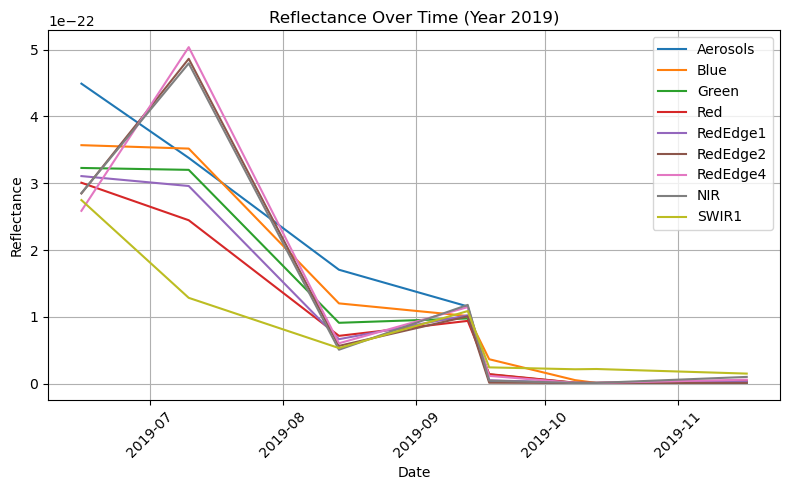

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2019
df_data_2019_onwards = df_data[df_data['Date'].dt.year == 2019]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2019_onwards['Band'].unique():
    df_band = df_data_2019_onwards[df_data_2019_onwards['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


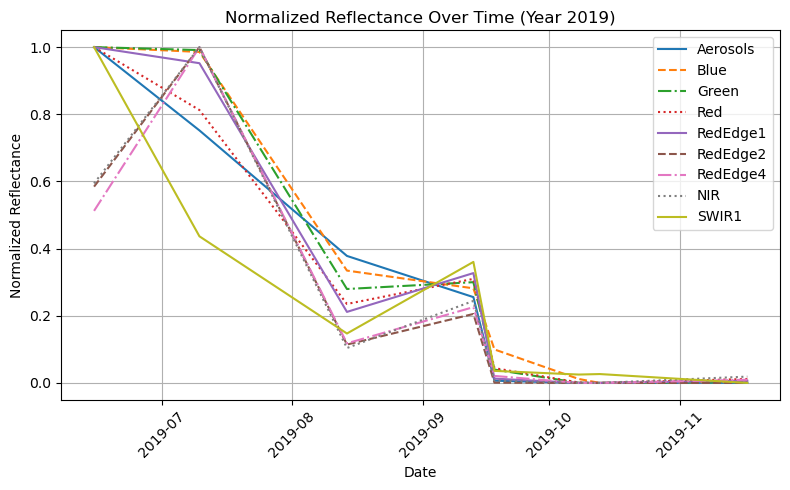

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2019_onwards = df_data[df_data['Date'].dt.year == 2019]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2019_onwards['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2019_onwards[df_data_2019_onwards['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


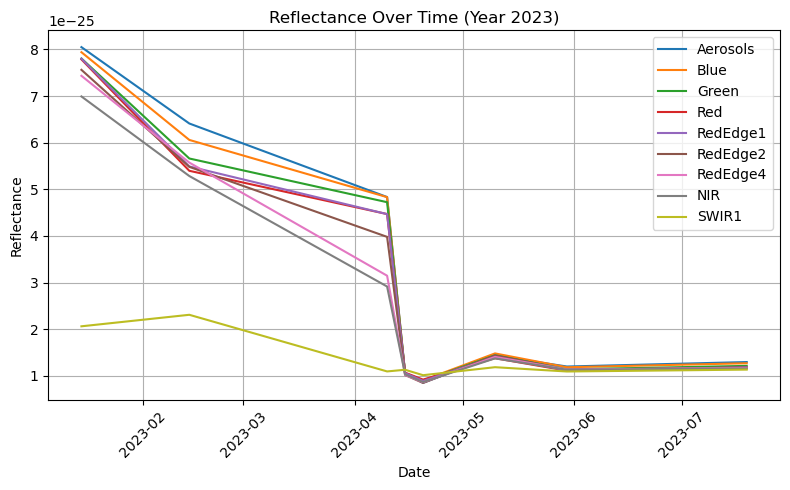

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2023['Band'].unique():
    df_band = df_data_2023[df_data_2023['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


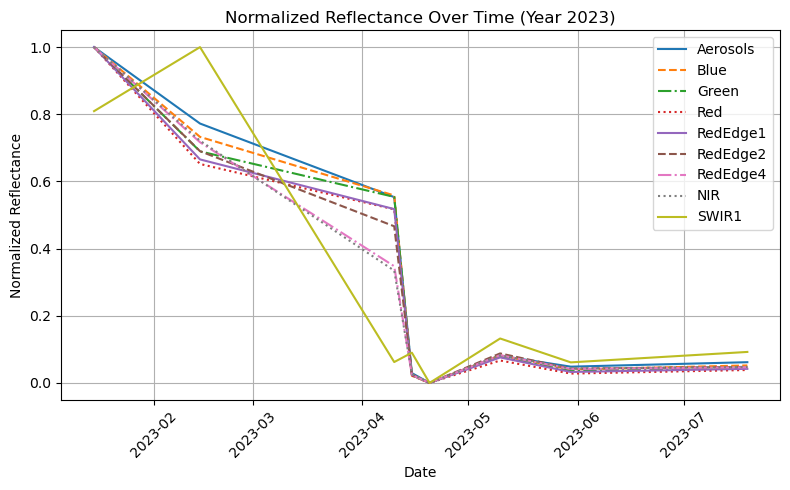

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the df_data DataFrame

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2023['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2023[df_data_2023['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
